<a href="https://colab.research.google.com/github/PSergey24/jupyter_notebooks/blob/main/NBA_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree

In [ ]:
# franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 8: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 35: 'Denver Nuggets', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}

In [2]:
franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 35: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}
def get_key(value):
    for k, v in franchises.items():
        if v == value:
            return k

def name_to_id(name):
  return get_key(name)

In [3]:
def union_data(df, df_odds):
  new_df = pd.merge(df, df_odds[['home_odd', 'visitor_odd', 'id_home', 'id_visitor', 'home_score','visitor_score']],  how='inner', left_on=['id_home', 'id_visitor', 'home_score','visitor_score'], right_on = ['id_home', 'id_visitor', 'home_score','visitor_score'])
  return new_df


In [4]:
def union_data_2(df_input):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_input['visitor_odd'] = 'empty'
  df_input['home_odd'] = 'empty' 
  for i, row in df_input.iterrows():
      # print(df_input.loc[i, :])
      info_odds = odds[(odds['id_home'] == df_input.loc[i, :]['id_home']) & (odds['id_visitor'] == df_input.loc[i, :]['id_visitor']) & (odds['home_score'] == df_input.loc[i, :]['home_score']) & (odds['visitor_score'] == df_input.loc[i, :]['visitor_score'])]
      if len(info_odds) != 1:
        continue
      df_input.at[i, 'visitor_odd'] = float(info_odds.visitor_odd)
      df_input.at[i, 'home_odd'] = float(info_odds.home_odd)
  return df_input

In [18]:
# months = {'jan': 1, 'feb': 2, 'mar': 3,  'nov': 11, 'dec': 12}
def get_month(date):
  month = date.split(',')[1].strip().split(' ')[0].strip().lower()
  return month

In [6]:
df_all = pd.read_csv('drive/MyDrive/Colab Notebooks/data/dataset_9_6_2022.csv', sep=',')
odds = pd.read_csv('drive/MyDrive/Colab Notebooks/data/odds.csv', sep='\t', index_col = [0])

In [7]:
df_all.rename({'pts_visitor': 'visitor_score', 'pts_home': 'home_score'}, axis=1, inplace=True)

In [8]:
df = df_all[(df_all['season'] > 2000) & (df_all['season'] < 2017)]

In [9]:
df_validate = df_all[df_all['season'] > 2016]

In [19]:
df = df[df[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
df_validate = df_validate[df_validate[['ELO_home', 't1p3_per', 't1p4_per', 't1p5_per', 't1p6_per', 't1p7_per', 't2p0_per', 't2p1_per', 't2p2_per', 't2p3_per', 't2p4_per', 't2p5_per', 't2p6_per', 't2p7_per']].notnull().all(1)]
df_validate['month'] = df_validate['date'].apply(get_month)
odds = odds.loc[(odds['home_odd'] != '-') & (odds['visitor_odd'] != '-')]
odds = odds.astype({"visitor_score": "Int64", "home_score": "Int64", "home_odd": "float32", "visitor_odd": "float32"})

In [20]:
odds['id_home'] = odds['home'].apply(lambda x: name_to_id(x))
odds['id_visitor'] = odds['visitor'].apply(lambda x: name_to_id(x))

In [21]:
# odds[odds['home'] == 'Denver Nuggets'].head(3)
odds.head(3)

,season,date,time,home,visitor,home_score,visitor_score,home_odd,visitor_odd,info,id_home,id_visitor
0,2017,12 Jun 2017,21:00,Golden State Warriors,Cleveland Cavaliers,129,120,1.26,4.19,NaN,10,6
1,2017,09 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,137,116,2.67,1.52,NaN,6,10
2,2017,07 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,113,118,2.39,1.64,NaN,6,10


In [22]:
# df_validate['visitor_odd'] = 'empty'
# df_validate['home_odd'] = 'empty'
df_validate.head(3)
# df_validate[df_validate['id_home'] == 35].head(3)

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,month
32344,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.574,0.483,0.470,0.386,0.344,0.266,0,0,1,oct
32348,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.515,0.404,0.320,0.265,0.224,0.211,0,0,1,oct
32349,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.463,0.413,0.403,0.389,0.359,0.246,0,1,1,oct


In [23]:
df_full_validate = union_data_2(df_validate)

In [24]:
df_full_validate = df_full_validate[(df_full_validate['visitor_odd'] != 'empty') | (df_full_validate['home_odd'] != 'empty')]
df_full_validate

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,month,visitor_odd,home_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.470,0.386,0.344,0.266,0,0,1,oct,2.36,1.69
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.320,0.265,0.224,0.211,0,0,1,oct,1.74,2.21
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.403,0.389,0.359,0.246,0,1,1,oct,1.27,4.04
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.233,0.212,0.175,0.121,0,0,1,oct,1.62,2.36
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.361,0.336,0.292,0.237,0,0,0,oct,1.45,3.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.463,0.358,0.344,0.333,0,0,0,may,3.26,1.37
7429,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.409,0.406,0.327,0.318,0,0,1,may,4.17,1.26
7430,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.272,0.204,0.195,0.161,0,0,1,may,1.68,2.27
7431,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,0.987,0.522,0.471,0.470,0,0,1,jun,2.43,1.61


In [ ]:
df_full_validate_2 = union_data(df_validate, odds)
df_full_validate_2

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,home_odd,visitor_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.483,0.470,0.386,0.344,0.266,0,0,1,1.69,2.36
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.404,0.320,0.265,0.224,0.211,0,0,1,2.21,1.74
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.413,0.403,0.389,0.359,0.246,0,1,1,4.04,1.27
3,59398,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,91,6,28,0.539,0.242,...,0.418,0.233,0.212,0.175,0.121,0,0,1,2.36,1.62
4,59399,https://www.basketball-reference.com/boxscores...,"Fri, Oct 28, 2016",2017,94,103,12,3,0.135,-0.413,...,0.485,0.361,0.336,0.292,0.237,0,0,0,3.01,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,66942,https://www.basketball-reference.com/boxscores...,"Thu, May 26, 2022",2022,110,120,7,10,0.329,0.447,...,0.578,0.463,0.358,0.344,0.333,0,0,0,1.37,3.26
7436,66943,https://www.basketball-reference.com/boxscores...,"Fri, May 27, 2022",2022,111,103,16,2,0.420,0.713,...,0.469,0.409,0.406,0.327,0.318,0,0,1,1.26,4.17
7437,66944,https://www.basketball-reference.com/boxscores...,"Sun, May 29, 2022",2022,100,96,2,16,0.647,0.486,...,0.390,0.272,0.204,0.195,0.161,0,0,1,2.27,1.68
7438,66945,https://www.basketball-reference.com/boxscores...,"Thu, Jun 2, 2022",2022,120,108,2,10,0.660,0.473,...,1.000,0.987,0.522,0.471,0.470,0,0,1,1.61,2.43


In [ ]:
df_validate['id_home'].unique()

array([24, 25, 26, 28,  3,  9, 21, 16,  7, 29, 19, 23,  4,  6, 20, 27, 17,
        5, 35, 13, 11, 15,  1, 12, 18, 30,  2, 22, 10, 14])

In [ ]:
df_validate['id_visitor'].unique()

array([26, 13, 27,  6, 12, 22, 24,  4, 11, 14, 10,  1,  2, 15, 19,  3, 25,
       18, 29, 17,  7, 30,  5, 35, 20, 23, 28,  9, 21, 16])

In [ ]:
df_full_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 0 to 7432
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7368 non-null   int64  
 1   link           7368 non-null   object 
 2   date           7368 non-null   object 
 3   season         7368 non-null   int64  
 4   visitor_score  7368 non-null   int64  
 5   home_score     7368 non-null   int64  
 6   id_visitor     7368 non-null   int64  
 7   id_home        7368 non-null   int64  
 8   ELO_visitor    7368 non-null   float64
 9   ELO_home       7368 non-null   float64
 10  t1p0_per       7368 non-null   float64
 11  t1p1_per       7368 non-null   float64
 12  t1p2_per       7368 non-null   float64
 13  t1p3_per       7368 non-null   float64
 14  t1p4_per       7368 non-null   float64
 15  t1p5_per       7368 non-null   float64
 16  t1p6_per       7368 non-null   float64
 17  t1p7_per       7368 non-null   float64
 18  t2p0_per

In [ ]:
df_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7433 entries, 32344 to 39898
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7433 non-null   int64  
 1   link           7433 non-null   object 
 2   date           7433 non-null   object 
 3   season         7433 non-null   int64  
 4   visitor_score  7433 non-null   int64  
 5   home_score     7433 non-null   int64  
 6   id_visitor     7433 non-null   int64  
 7   id_home        7433 non-null   int64  
 8   ELO_visitor    7433 non-null   float64
 9   ELO_home       7433 non-null   float64
 10  t1p0_per       7433 non-null   float64
 11  t1p1_per       7433 non-null   float64
 12  t1p2_per       7433 non-null   float64
 13  t1p3_per       7433 non-null   float64
 14  t1p4_per       7433 non-null   float64
 15  t1p5_per       7433 non-null   float64
 16  t1p6_per       7433 non-null   float64
 17  t1p7_per       7433 non-null   float64
 18  t2p

In [ ]:
odds.head(3)

,season,date,time,home,visitor,home_score,visitor_score,home_odd,visitor_odd,info,id_home,id_visitor
0,2017,12 Jun 2017,21:00,Golden State Warriors,Cleveland Cavaliers,129,120,1.26,4.19,NaN,10,6
1,2017,09 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,137,116,2.67,1.52,NaN,6,10
2,2017,07 Jun 2017,21:00,Cleveland Cavaliers,Golden State Warriors,113,118,2.39,1.64,NaN,6,10


In [ ]:
df_full_validate.head(3)

,id,link,date,season,visitor_score,home_score,id_visitor,id_home,ELO_visitor,ELO_home,...,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y,visitor_odd,home_odd
0,59392,https://www.basketball-reference.com/boxscores...,"Wed, Oct 26, 2016",2017,113,94,26,24,-0.206,-0.395,...,0.483,0.470,0.386,0.344,0.266,0,0,1,2.36,1.69
1,59396,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,114,106,13,25,0.285,0.274,...,0.404,0.320,0.265,0.224,0.211,0,0,1,1.74,2.21
2,59397,https://www.basketball-reference.com/boxscores...,"Thu, Oct 27, 2016",2017,102,94,27,26,0.549,-0.089,...,0.413,0.403,0.389,0.359,0.246,0,1,1,1.27,4.04


In [25]:
df = df.loc[:, 'ELO_visitor':]

In [26]:
train_df, test_df = train_test_split(df, test_size=2000)

In [27]:
train_df.head(3)

,ELO_visitor,ELO_home,t1p0_per,t1p1_per,t1p2_per,t1p3_per,t1p4_per,t1p5_per,t1p6_per,t1p7_per,...,t2p1_per,t2p2_per,t2p3_per,t2p4_per,t2p5_per,t2p6_per,t2p7_per,visitor_b2b,home_b2b,Y
29353,-0.546,-0.177,0.547,0.440,0.421,0.420,0.373,0.299,0.263,0.245,...,0.554,0.484,0.436,0.428,0.402,0.392,0.343,0,0,0
29995,0.146,0.375,0.656,0.503,0.422,0.356,0.350,0.315,0.284,0.251,...,0.386,0.302,0.298,0.261,0.232,0.196,0.180,1,1,0
17365,-0.408,0.356,1.000,1.000,0.832,0.440,0.402,0.324,0.311,0.300,...,0.539,0.369,0.336,0.308,0.235,0.209,0.165,0,0,0


In [28]:
train_features = train_df.loc[:, 'ELO_visitor':'home_b2b']
Y = train_df.loc[:, 'Y']

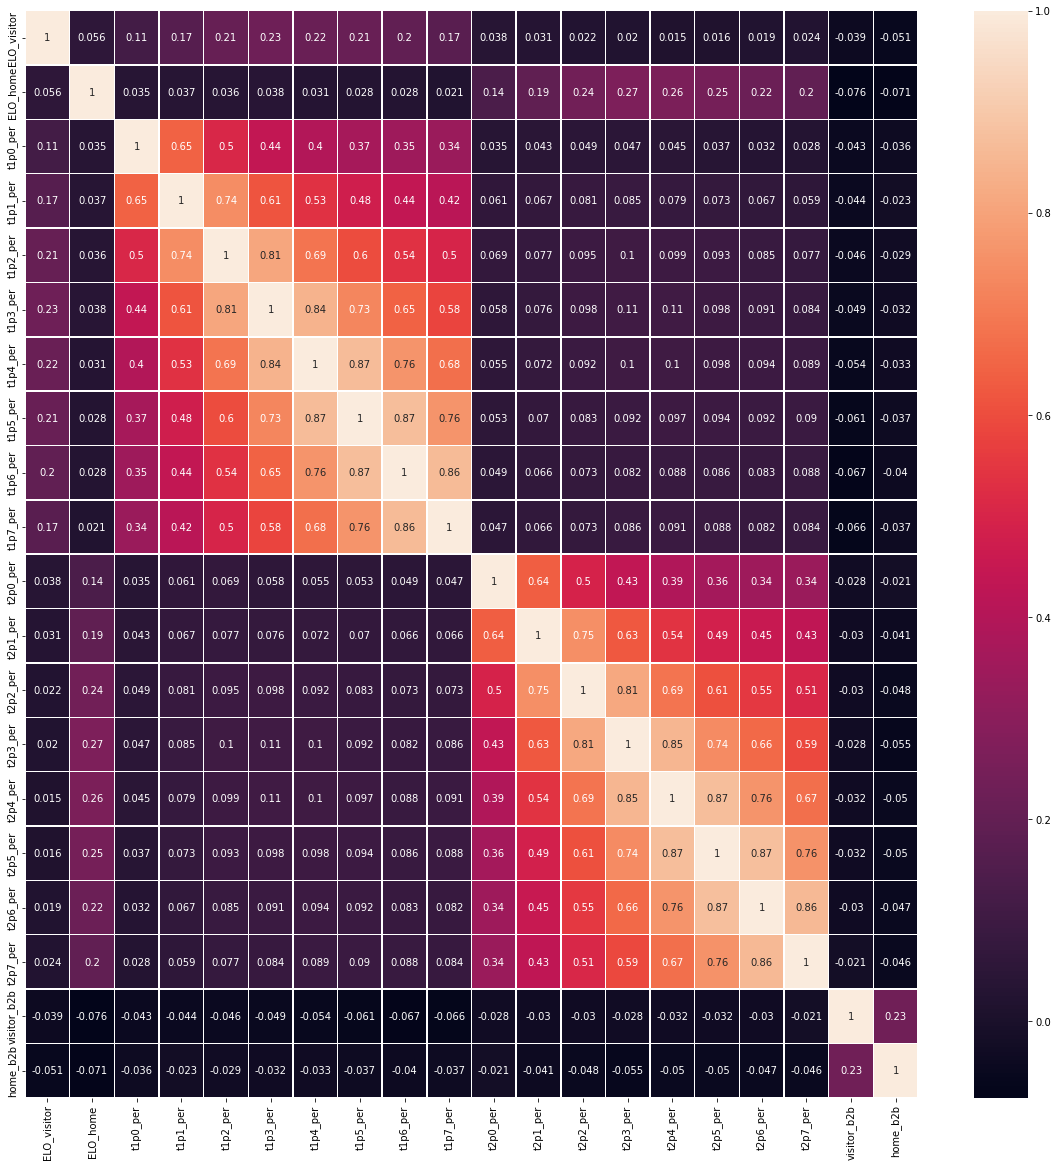

In [68]:
corr_matrix = train_features.corr()

#Using heatmap to visualize the correlation matrix
fig, ax = plt.subplots(figsize=(20,20)) 
sn.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax)

In [29]:
model = LogisticRegression(random_state=0)
model.fit(train_features, Y)

LogisticRegression(random_state=0)

In [30]:
test_features = test_df.loc[:, 'ELO_visitor':'home_b2b']
test_Y = test_df.loc[:, 'Y']

In [31]:
model_pipeline = Pipeline(
    [
        ('model', LogisticRegression(random_state=0))
    ]
)

In [32]:
model_pipeline.fit(train_features, Y)

Pipeline(steps=[('model', LogisticRegression(random_state=0))])

In [33]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.6402027027027027

In [34]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict(test_features))

0.46219512195121953

In [35]:
prec, rec, thresholds = precision_recall_curve(y_true=test_Y, probas_pred=model_pipeline.predict_proba(test_features)[:, 1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


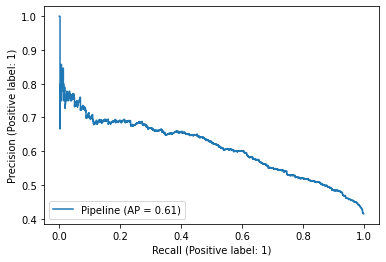

In [36]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_features, y=test_Y)

In [37]:
np.where(prec > 0.75)

(array([1903, 1904, 1905, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
        1932, 1933, 1935, 1936, 1937, 1939, 1940, 1941, 1942, 1943, 1944,
        1945, 1947, 1948, 1949, 1951, 1952, 1953, 1957, 1959, 1960, 1961,
        1963, 1964, 1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1976,
        1977, 1978]),)

In [38]:
thresholds[1903]

0.749442041301815

In [39]:
precision_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1903])

0.7567567567567568

In [40]:
recall_score(y_true=test_Y, y_pred=model_pipeline.predict_proba(test_features)[:, 1] > thresholds[1903])

0.06829268292682927

In [41]:
grid_pipeline = Pipeline(
    [
        ('model', 
          GridSearchCV(
            LogisticRegression(random_state=0, max_iter=5000),
            param_grid={'C': [0.1, 1, 10.]},
            cv=3,
            verbose=4
            )
        )
    ]
)

In [42]:
grid_pipeline.fit(train_features, Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.673 total time=   0.1s
[CV 2/3] END .............................C=0.1;, score=0.678 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.674 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.671 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.677 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.675 total time=   0.2s
[CV 1/3] END ............................C=10.0;, score=0.670 total time=   0.3s
[CV 2/3] END ............................C=10.0;, score=0.675 total time=   0.2s
[CV 3/3] END ............................C=10.0;, score=0.676 total time=   0.2s


Pipeline(steps=[('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(max_iter=5000,
                                                           random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [56]:
def to_get_results(df_input, model_input, comment):
  df_input = df_input.copy()
  df_input.reset_index(drop=True, inplace=True)
  df_validate_features = df_input.loc[:, 'ELO_visitor':'home_b2b']
  df_validate_y = df_input.loc[:, 'Y']

  # active_thresholds = thresholds[1903]
  # active_thresholds = 0.5
  # predictions = model_pipeline.predict_proba(df_validate_features)[:, 1] > active_thresholds
  # predictions = model_pipeline.predict(df_validate_features)
  predictions = model_input.predict(df_validate_features)

  real_results = df_validate_y.tolist()

  bet_size = 100
  total_bet = 0
  total_win = 0

  step = []
  money = []
  current = 0

  good_precision = 0

  for i, prediction in enumerate(predictions):
    visitor_odd = df_input.loc[i, 'visitor_odd']
    home_odd = df_input.loc[i, 'home_odd']

    # print(f'step {i}: {real_results[i]}, {bool(real_results[i])}, {prediction}')

    if bool(real_results[i]) == prediction:
      if prediction is True:
        total_win += bet_size * float(visitor_odd)
        current += bet_size * float(visitor_odd)
        # print(f'WIN: {bet_size * float(visitor_odd)}')
      else:
        total_win += bet_size * float(home_odd)
        current += bet_size * float(home_odd)
        # print(f'WIN: {bet_size * float(home_odd)}')
      good_precision += 1

    # print(df_full_validate.loc[i])
    
    total_bet += bet_size
    current -= bet_size
    money.append(current)
    step.append(i)

  print(f'ROI = {total_win/total_bet}, comment = {comment}, accuracy = {good_precision / len(df_validate_y)}, count_bets = {total_bet/bet_size}, wins = {total_win}, bets = {total_bet}, cash = {total_win - total_bet}')

  plt.plot(step, money, label=comment)

  plt.legend()
  plt.xlabel('step')
  plt.ylabel('money')


In [ ]:
# save csv
df_full_validate.to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds.csv', sep='\t', encoding='utf-8')

In [ ]:
# save csv
df_full_validate[df_full_validate['season'] > 2016].to_csv('drive/MyDrive/Colab Notebooks/data/games_with_odds_2017.csv', sep='\t', encoding='utf-8')

In [44]:
# decision trees, 2017-2022 seasons
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_features, Y)

ROI = 1.2886617802059224, accuracy = 0.6429153094462541, count_bets = 7368.0, wins = 949485.9996557236, bets = 736800, cash = 212685.99965572357
ROI = 1.1593023878678954, accuracy = 0.5840119435396308, count_bets = 7368.0, wins = 854173.9993810654, bets = 736800, cash = 117373.99938106537


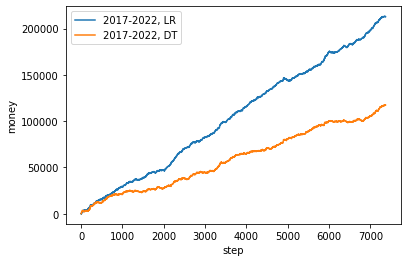

In [45]:
# linear regression, decision tress 2017-2022 seasons
to_get_results(df_full_validate, model_pipeline, '2017-2022, LR')
to_get_results(df_full_validate, clf, '2017-2022, DT')

ROI = 1.2815511802988728, comment = 2017, accuracy = 0.6480314960629922, count_bets = 1270.0, wins = 162756.99989795685, bets = 127000, cash = 35756.99989795685
ROI = 1.279027237873597, comment = 2018, accuracy = 0.6568093385214008, count_bets = 1285.0, wins = 164355.0000667572, bets = 128500, cash = 35855.0000667572
ROI = 1.3053234585169602, comment = 2019, accuracy = 0.6562743569758379, count_bets = 1283.0, wins = 167472.99972772598, bets = 128300, cash = 39172.99972772598
ROI = 1.3147259663592987, comment = 2020, accuracy = 0.6531895777178796, count_bets = 1113.0, wins = 146329.00005578995, bets = 111300, cash = 35029.00005578995
ROI = 1.249552238500359, comment = 2021, accuracy = 0.6022827041264267, count_bets = 1139.0, wins = 142323.9999651909, bets = 113900, cash = 28423.999965190887
ROI = 1.3008450699710696, comment = 2022, accuracy = 0.6377151799687011, count_bets = 1278.0, wins = 166247.9999423027, bets = 127800, cash = 38447.999942302704


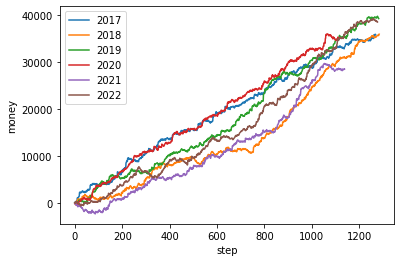

In [51]:
# linear regression
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, model_pipeline, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, model_pipeline, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, model_pipeline, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, model_pipeline, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, model_pipeline, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, model_pipeline, '2022')

ROI = 1.186811023246585, accuracy = 0.6015748031496063, count_bets = 1270.0, wins = 150724.99995231628, bets = 127000, cash = 23724.999952316284
ROI = 1.1047704279190835, accuracy = 0.5774319066147859, count_bets = 1285.0, wins = 141962.99998760223, bets = 128500, cash = 13462.999987602234
ROI = 1.2099064668453214, accuracy = 0.6134060795011691, count_bets = 1283.0, wins = 155230.99969625473, bets = 128300, cash = 26930.99969625473
ROI = 1.1439442946261793, accuracy = 0.5786163522012578, count_bets = 1113.0, wins = 127320.99999189377, bets = 111300, cash = 16020.999991893768
ROI = 1.1723002626563082, accuracy = 0.5627743634767339, count_bets = 1139.0, wins = 133524.9999165535, bets = 113900, cash = 19624.999916553497
ROI = 1.137785601224138, accuracy = 0.5672926447574335, count_bets = 1278.0, wins = 145408.99983644485, bets = 127800, cash = 17608.999836444855


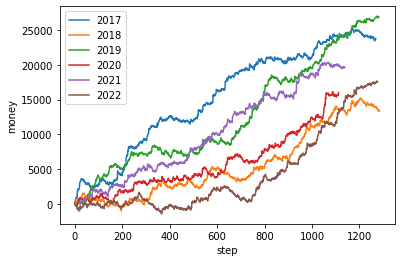

In [47]:
season = df_full_validate[df_full_validate['season'] == 2017]
to_get_results(season, clf, '2017')

season = df_full_validate[df_full_validate['season'] == 2018]
to_get_results(season, clf, '2018')

season = df_full_validate[df_full_validate['season'] == 2019]
to_get_results(season, clf, '2019')

season = df_full_validate[df_full_validate['season'] == 2020]
to_get_results(season, clf, '2020')

season = df_full_validate[df_full_validate['season'] == 2021]
to_get_results(season, clf, '2021')

season = df_full_validate[df_full_validate['season'] == 2022]
to_get_results(season, clf, '2022')

ROI = 1.2222781043786268, comment = oct, accuracy = 0.621301775147929, count_bets = 338.0, wins = 41312.99992799759, bets = 33800, cash = 7512.999927997589
ROI = 1.2665233301222052, comment = nov, accuracy = 0.6486733760292772, count_bets = 1093.0, wins = 138430.99998235703, bets = 109300, cash = 29130.999982357025
ROI = 1.20358638665647, comment = dec, accuracy = 0.618673647469459, count_bets = 1146.0, wins = 137930.99991083145, bets = 114600, cash = 23330.99991083145
ROI = 1.2476870751434983, comment = jan, accuracy = 0.6424792139077853, count_bets = 1323.0, wins = 165069.00004148483, bets = 132300, cash = 32769.00004148483
ROI = 1.3629681276847643, comment = feb, accuracy = 0.6593625498007968, count_bets = 1004.0, wins = 136842.00001955032, bets = 100400, cash = 36442.00001955032
ROI = 1.4043470936456244, comment = mar, accuracy = 0.6663858466722831, count_bets = 1187.0, wins = 166696.00001573563, bets = 118700, cash = 47996.000015735626
ROI = 1.2802645486814004, comment = apr, accu

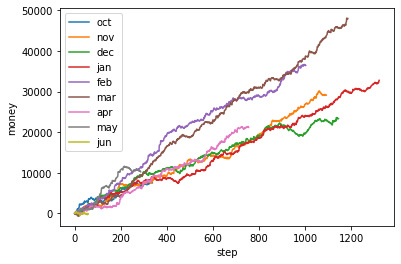

In [52]:
# linear regression by months
season = df_full_validate[df_full_validate['month'] == 'oct']
to_get_results(season, model_pipeline, 'oct')

season = df_full_validate[df_full_validate['month'] == 'nov']
to_get_results(season, model_pipeline, 'nov')

season = df_full_validate[df_full_validate['month'] == 'dec']
to_get_results(season, model_pipeline, 'dec')

season = df_full_validate[df_full_validate['month'] == 'jan']
to_get_results(season, model_pipeline, 'jan')

season = df_full_validate[df_full_validate['month'] == 'feb']
to_get_results(season, model_pipeline, 'feb')

season = df_full_validate[df_full_validate['month'] == 'mar']
to_get_results(season, model_pipeline, 'mar')

season = df_full_validate[df_full_validate['month'] == 'apr']
to_get_results(season, model_pipeline, 'apr')

season = df_full_validate[df_full_validate['month'] == 'may']
to_get_results(season, model_pipeline, 'may')

season = df_full_validate[df_full_validate['month'] == 'jun']
to_get_results(season, model_pipeline, 'jun')

ROI = 0.9865703944264766, comment = Boston Celtics, accuracy = 0.6534296028880866, count_bets = 277.0, wins = 27327.999925613403, bets = 27700, cash = -372.0000743865967
ROI = 1.4981385293977085, comment = Chicago, accuracy = 0.6147186147186147, count_bets = 231.0, wins = 34607.00002908707, bets = 23100, cash = 11507.000029087067
ROI = 1.1425373136107602, comment = Golden State, accuracy = 0.7350746268656716, count_bets = 268.0, wins = 30620.00000476837, bets = 26800, cash = 3820.0000047683716
ROI = 1.2785714241923118, comment = Los Angeles Lakers, accuracy = 0.5959183673469388, count_bets = 245.0, wins = 31324.99989271164, bets = 24500, cash = 6824.999892711639
ROI = 1.7962660927629266, comment = New York, accuracy = 0.6437768240343348, count_bets = 233.0, wins = 41852.99996137619, bets = 23300, cash = 18552.99996137619
ROI = 1.4885021994292473, comment = Sacramento, accuracy = 0.5859030837004405, count_bets = 227.0, wins = 33788.999927043915, bets = 22700, cash = 11088.999927043915


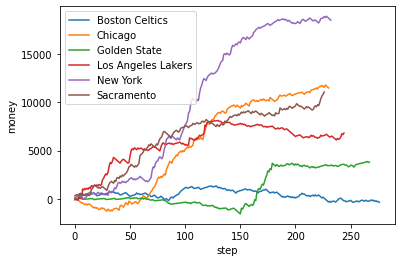

In [61]:
# linear regression by teams (home)
# franchises = {1: 'Atlanta Hawks', 2: 'Boston Celtics', 3: 'Brooklyn Nets', 4: 'Charlotte Hornets', 5: 'Chicago Bulls', 6: 'Cleveland Cavaliers', 7: 'Dallas Mavericks', 35: 'Denver Nuggets', 9: 'Detroit Pistons', 10: 'Golden State Warriors', 11: 'Houston Rockets', 12: 'Indiana Pacers', 13: 'Los Angeles Clippers', 14: 'Los Angeles Lakers', 15: 'Memphis Grizzlies', 16: 'Miami Heat', 17: 'Milwaukee Bucks', 18: 'Minnesota Timberwolves', 19: 'New Orleans Pelicans', 20: 'New York Knicks', 21: 'Oklahoma City Thunder', 22: 'Orlando Magic', 23: 'Philadelphia 76ers', 24: 'Phoenix Suns', 25: 'Portland Trail Blazers', 26: 'Sacramento Kings', 27: 'San Antonio Spurs', 28: 'Toronto Raptors', 29: 'Utah Jazz', 30: 'Washington Wizards', 31: 'Anderson Packers', 32: 'Baltimore Bullets', 33: 'Chicago Stags', 34: 'Cleveland Rebels', 36: 'Detroit Falcons', 37: 'Indianapolis Jets', 38: 'Indianapolis Olympians', 39: 'Kentucky Colonels', 40: 'Memphis Sounds', 41: 'Pittsburgh Condors', 42: 'Pittsburgh Ironmen', 43: 'Providence Steam Rollers', 44: 'San Diego Sails', 45: 'Sheboygan Red Skins', 46: 'Spirits of St. Louis', 47: 'St. Louis Bombers', 48: 'The Floridians', 49: 'Toronto Huskies', 50: 'Utah Stars', 51: 'Virginia Squires', 52: 'Washington Capitols', 53: 'Waterloo Hawks'}
season = df_full_validate[df_full_validate['id_home'] == 2]
to_get_results(season, model_pipeline, 'Boston Celtics')

season = df_full_validate[df_full_validate['id_home'] == 5]
to_get_results(season, model_pipeline, 'Chicago')

season = df_full_validate[df_full_validate['id_home'] == 10]
to_get_results(season, model_pipeline, 'Golden State')

season = df_full_validate[df_full_validate['id_home'] == 14]
to_get_results(season, model_pipeline, 'Los Angeles Lakers')

season = df_full_validate[df_full_validate['id_home'] == 20]
to_get_results(season, model_pipeline, 'New York')

season = df_full_validate[df_full_validate['id_home'] == 26]
to_get_results(season, model_pipeline, 'Sacramento')

ROI = 1.4490109896048522, comment = Boston Celtics, accuracy = 0.5897435897435898, count_bets = 273.0, wins = 39558.00001621246, bets = 27300, cash = 12258.000016212463
ROI = 0.9593534469604492, comment = Chicago, accuracy = 0.6336206896551724, count_bets = 232.0, wins = 22256.999969482422, bets = 23200, cash = -943.0000305175781
ROI = 2.3422348472205075, comment = Golden State, accuracy = 0.6666666666666666, count_bets = 264.0, wins = 61834.9999666214, bets = 26400, cash = 35434.9999666214
ROI = 1.2481967196112773, comment = Los Angeles Lakers, accuracy = 0.6270491803278688, count_bets = 244.0, wins = 30455.999958515167, bets = 24400, cash = 6055.999958515167
ROI = 1.0266521744106127, comment = New York, accuracy = 0.691304347826087, count_bets = 230.0, wins = 23613.00001144409, bets = 23000, cash = 613.0000114440918
ROI = 0.9571428562139536, comment = Sacramento, accuracy = 0.6363636363636364, count_bets = 231.0, wins = 22109.999978542328, bets = 23100, cash = -990.0000214576721


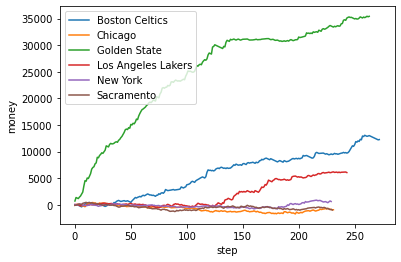

In [63]:
# linear regression by teams (away)
season = df_full_validate[df_full_validate['id_visitor'] == 2]
to_get_results(season, model_pipeline, 'Boston Celtics')

season = df_full_validate[df_full_validate['id_visitor'] == 5]
to_get_results(season, model_pipeline, 'Chicago')

season = df_full_validate[df_full_validate['id_visitor'] == 10]
to_get_results(season, model_pipeline, 'Golden State')

season = df_full_validate[df_full_validate['id_visitor'] == 14]
to_get_results(season, model_pipeline, 'Los Angeles Lakers')

season = df_full_validate[df_full_validate['id_visitor'] == 20]
to_get_results(season, model_pipeline, 'New York')

season = df_full_validate[df_full_validate['id_visitor'] == 26]
to_get_results(season, model_pipeline, 'Sacramento')


ROI = 1.1888235339931412, comment = oct 2020, accuracy = 0.6666666666666666, count_bets = 51.0, wins = 6063.000023365021, bets = 5100, cash = 963.0000233650208
ROI = 1.420372093555539, comment = nov 2020, accuracy = 0.7395348837209302, count_bets = 215.0, wins = 30538.00001144409, bets = 21500, cash = 9038.000011444092
ROI = 1.2740366989319478, comment = dec 2020, accuracy = 0.6284403669724771, count_bets = 218.0, wins = 27774.00003671646, bets = 21800, cash = 5974.000036716461
ROI = 1.2933031687369714, comment = jan 2020, accuracy = 0.6470588235294118, count_bets = 221.0, wins = 28582.000029087067, bets = 22100, cash = 6482.000029087067
ROI = 1.3019631888968812, comment = feb 2020, accuracy = 0.6748466257668712, count_bets = 163.0, wins = 21221.999979019165, bets = 16300, cash = 4921.999979019165


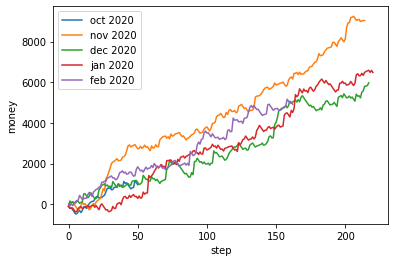

In [64]:
# linear regression by months
season = df_full_validate[(df_full_validate['month'] == 'oct') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'oct 2020')

season = df_full_validate[(df_full_validate['month'] == 'nov') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'nov 2020')

season = df_full_validate[(df_full_validate['month'] == 'dec') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'dec 2020')

season = df_full_validate[(df_full_validate['month'] == 'jan') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'jan 2020')

season = df_full_validate[(df_full_validate['month'] == 'feb') & (df_full_validate['season'] == 2020)]
to_get_results(season, model_pipeline, 'feb 2020')